In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import replace
import json
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from tqdm.auto import tqdm

from src.datasets.speech_equivalence import SpeechHiddenStateDataset
from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory
from src.analysis.trf import coefs_to_df
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.utils.timit import get_word_metadata

In [4]:
dataset = "timit-no_repeats"
state_space_name = "phoneme"

# base_model = "w2v2_8"
# model_class = "rnn_8-aniso2"
# model_name = "word_broad"

base_model = "w2v2_6"
model_class = "rnn_8-weightdecay0.01"
model_name = "biphone_recon"

model_dir = f"outputs/models/{dataset}/{base_model}/{model_class}/{model_name}_10frames"
output_dir = f"outputs/notebooks/{dataset}/{base_model}/{model_class}/{model_name}_10frames/state_space"
dataset_path = f"outputs/preprocessed_data/{dataset}"
equivalence_path = f"outputs/equivalence_datasets/{dataset}/{base_model}/{model_name}_10frames/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{dataset}/{base_model}/hidden_states.pkl"
state_space_specs_path = f"outputs/state_space_specs/{dataset}/{base_model}/state_space_specs.pkl"
embeddings_path = f"outputs/model_embeddings/{dataset}/{base_model}/{model_class}/{model_name}_10frames/embeddings.npy"

subjects = ["EC196", "EC212", "EC260"]
# encoder_name = "word_broad-aniso2-w2v2_8"
encoder_name = "biphone_recon"
encoder_dirs = {subject: Path(f"outputs/encoders/{dataset}") / encoder_name / subject for subject in subjects}

metric = "cosine"

In [5]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
# with open(state_space_specs_path, "rb") as f:
#     state_space_spec: StateSpaceAnalysisSpec = torch.load(f)[state_space_name]
with open(hidden_states_path, "rb") as f:
    hidden_states: SpeechHiddenStateDataset = torch.load(f)
dataset = datasets.load_from_disk(dataset_path)
# assert state_space_spec.is_compatible_with(model_representations)

In [6]:
def compute_biphone_state_space(dataset: datasets.Dataset,
                                hidden_state_dataset: SpeechHiddenStateDataset,
                                ):
    frames_by_item = hidden_state_dataset.frames_by_item

    from collections import defaultdict
    frame_spans_by_biphone = defaultdict(list)
    cuts_df = []

    def process_item(item):
        # How many frames do we have stored for this item?
        start_frame, stop_frame = frames_by_item[item["idx"]]
        num_frames = stop_frame - start_frame

        compression_ratio = num_frames / len(item["input_values"])

        for word in item["word_phonemic_detail"]:
            if len(word) == 0:
                continue

            start_dummy = {"phone": "#", "start": word[0]["start"], "stop": word[0]["stop"]}
            end_dummy = {"phone": "#", "start": word[-1]["start"], "stop": word[-1]["stop"]}
            word = [start_dummy] + word + [end_dummy]
                                     
            for i, (p1, p2) in enumerate(zip(word, word[1:])):
                biphone_start_frame = start_frame + int(p1["start"] * compression_ratio)
                biphone_stop_frame = start_frame + int(p2["stop"] * compression_ratio)

                biphone_label = (p1["phone"], p2["phone"])
                instance_idx = len(frame_spans_by_biphone[biphone_label])
                frame_spans_by_biphone[biphone_label].append((biphone_start_frame, biphone_stop_frame))

                # add constituent phonemes to cuts
                cuts_df.append({
                    "label": biphone_label,
                    "instance_idx": instance_idx,
                    "level": "phoneme",
                    "description": p1["phone"],
                    "onset_frame_idx": start_frame + int(p1["start"] * compression_ratio),
                    "offset_frame_idx": start_frame + int(p1["stop"] * compression_ratio),
                    "item_idx": item["idx"],
                })
                cuts_df.append({
                    "label": biphone_label,
                    "instance_idx": instance_idx,
                    "level": "phoneme",
                    "description": p2["phone"],
                    "onset_frame_idx": start_frame + int(p2["start"] * compression_ratio),
                    "offset_frame_idx": start_frame + int(p2["stop"] * compression_ratio),
                    "item_idx": item["idx"],
                })

    dataset.map(process_item, batched=False)

    biphones = sorted(frame_spans_by_biphone.keys())
    return StateSpaceAnalysisSpec(
        total_num_frames=hidden_state_dataset.num_frames,
        labels=biphones,
        target_frame_spans = [frame_spans_by_biphone[b] for b in biphones],
        cuts=pd.DataFrame(cuts_df).set_index(["label", "instance_idx", "level"]).sort_index(),
    )


In [7]:
state_space_spec = compute_biphone_state_space(dataset, hidden_states)
# gc these guys now
dataset = None
hidden_states = None

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

In [8]:
assert state_space_spec.is_compatible_with(model_representations)

In [9]:
encoders = {subject: torch.load(encoder_dir / "model.pkl") for subject, encoder_dir in encoder_dirs.items()}
electrode_df = pd.concat([pd.read_csv(encoder_dir / "electrodes.csv", index_col="electrode_idx") for encoder_dir in encoder_dirs.values()],
                         keys=subjects, names=["subject", "electrode_idx"])

In [10]:
coefs, model_embedding_coefs = {}, {}
electrode_names = {}
coef_dfs = {}
for subject, encoder_dir in tqdm(encoder_dirs.items()):
    num_fit_electrodes = encoders[subject].coef_.shape[0]
    electrode_names[subject] = electrode_df.loc[subject].head(num_fit_electrodes).electrode_name

    coefs_i = np.stack(torch.load(encoder_dir / "coefs.pkl"))
    coefs[subject] = coefs_i
    model_embedding_coefs[subject] = coefs_i[:, :, [idx for idx, name in enumerate(encoders[subject].feature_names)
                                                    if name.startswith("model_embedding")]]

    coef_dfs[subject] = coefs_to_df(coefs_i, encoders[subject].feature_names,
                                    electrode_names[subject], encoders[subject].sfreq)

  0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
coef_df = pd.concat(coef_dfs, names=["subject"]).reset_index()
coef_df["electrode_label"] = coef_df.subject.str.cat(coef_df.output_dim.astype(str), sep="_")

## Embedding PCA analysis

In [11]:
len(state_space_spec.labels)

1179

In [12]:
trajectory = prepare_state_trajectory(
    model_representations,
    state_space_spec,
    pad=np.nan
)

In [13]:
trajectory = aggregate_state_trajectory(trajectory, "mean", keepdims=True)

In [14]:
all_trajectories_full = np.concatenate(trajectory)
all_trajectories_src = np.concatenate([
    np.stack([np.ones(traj_i.shape[0]) * idx, np.arange(traj_i.shape[0])]).T
    for idx, traj_i in enumerate(trajectory)
]).astype(int)

# flatten & retain non-padding
all_trajectories = all_trajectories_full.reshape(-1, all_trajectories_full.shape[-1])
retain_idxs = ~np.isnan(all_trajectories).any(axis=1)
all_trajectories = all_trajectories[retain_idxs]
all_trajectories_src = all_trajectories_src[retain_idxs]

all_trajectories_estimation = all_trajectories

# # for PCA estimation, retain only those words with at least `pca_min_freq`

# # retain just `pca_min_freq` instances of each word for PCA estimation, to make sure the space
# # is not biased for frequent words
# retain_idxs_estimation = []
# for label_idx in range(len(trajectory)):
#     traj_idxs = np.where(all_trajectories_src[:, 0] == label_idx)[0]
#     retain_idxs_estimation.append(np.random.choice(
#         traj_idxs, min(len(traj_idxs), pca_min_freq), replace=False))
# retain_idxs_estimation = np.concatenate(retain_idxs_estimation)
# all_trajectories_estimation = all_trajectories[retain_idxs_estimation]
# all_trajectories_src_estimation = all_trajectories_src[retain_idxs_estimation]

In [15]:
pca = PCA(n_components=4)
pca.fit(all_trajectories_estimation)

all_trajectories_pca = pca.transform(all_trajectories)

In [16]:
pca.explained_variance_ratio_

array([6.57126958e-01, 2.07350421e-01, 1.35302602e-01, 1.67749148e-04])

In [17]:
pca_coefs = {subject: pca.transform(model_coefs_i.transpose((0, 1, 3, 2)).reshape((-1, 8))) \
    .reshape(model_coefs_i.shape[:2] + (61, pca.n_components_)).transpose((0, 1, 3, 2))
    for subject, model_coefs_i in model_embedding_coefs.items()}
pca_coefs = {subject: pca_coefs_i - pca_coefs_i[:, :, :, :1] for subject, pca_coefs_i in pca_coefs.items()}
{subject: c.shape for subject, c in pca_coefs.items()}

{'EC196': (3, 256, 4, 61), 'EC212': (3, 384, 4, 61), 'EC260': (3, 256, 4, 61)}

In [18]:
pca_coef_df = pd.concat({
    subject: coefs_to_df(
        pca_coefs_i, [f"pca_{i}" for i in range(pca.n_components_)],
        electrode_names[subject], encoders[subject].sfreq)
    for subject, pca_coefs_i in pca_coefs.items()
    }, names=["subject"]).reset_index()
pca_coef_df["electrode_label"] = pca_coef_df.subject.str.cat(pca_coef_df.output_dim.astype(str), sep="_")

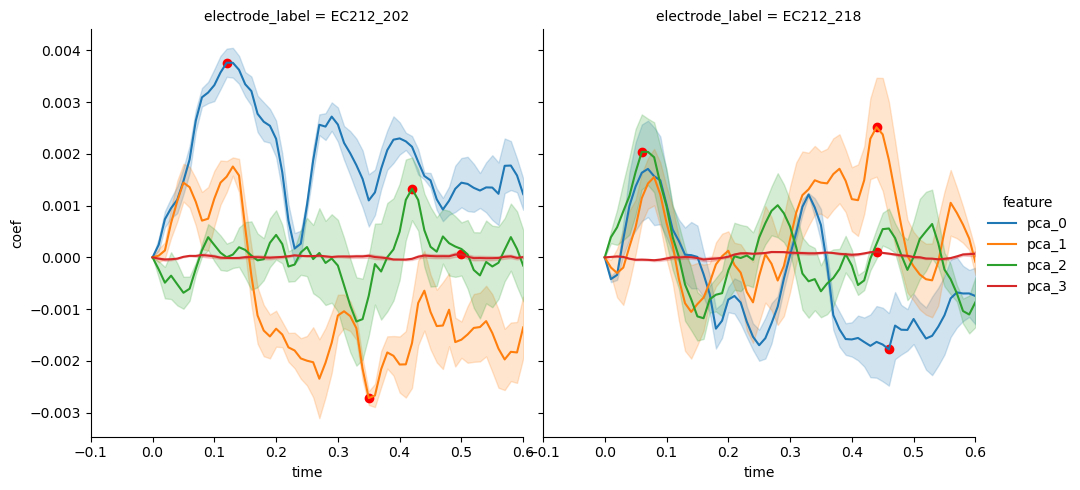

In [25]:
# plot word-dominant electrodes in PC space
# word_dominant = sorted([f"EC212_{dim}" for dim in [220, 214, 107, 74, 114, 211]] + \
#     [f"EC196_{dim}" for dim in [185, 233, 8]] + \
#     [f"EC260_{dim}" for dim in [3, 84, 92, 126, 208, 210, 216]])
# word-dominant according to estimation on timit-no_repeats
biphone_pred_dominant = \
    [f"EC212_{dim}" for dim in sorted([301, 87])]# + \
    # [f"EC260_{dim}" for dim in sorted([211, 175, 129, 218])]
biphone_recon_dominant = \
    [f"EC212_{dim}" for dim in sorted([202, 218])]
hue_order = [f"pca_{i}" for i in range(pca.n_components_)]
col_order = biphone_recon_dominant
g = sns.relplot(data=pca_coef_df[pca_coef_df.electrode_label.isin(biphone_recon_dominant)],
                col="electrode_label", col_wrap=2, col_order=col_order,
                x="time", y="coef",
                hue="feature", hue_order=hue_order,
                kind="line", errorbar="se", facet_kws=dict(sharex=False))

max_points = {}
for (row, col, hue), facet_data in g.facet_data():
    ax = g.facet_axis(row, col)
    ax.set_xlim((-0.1, 0.6))

    for feature, feature_rows in facet_data.groupby("feature"):
        facet_means = feature_rows.groupby("time").coef.mean()
        max_point = np.abs(facet_means).idxmax()
        ax.scatter(max_point, facet_means.loc[max_point], color="red")

        output_dim = feature_rows.output_dim.iloc[0]
        max_points[output_dim, feature] = max_point

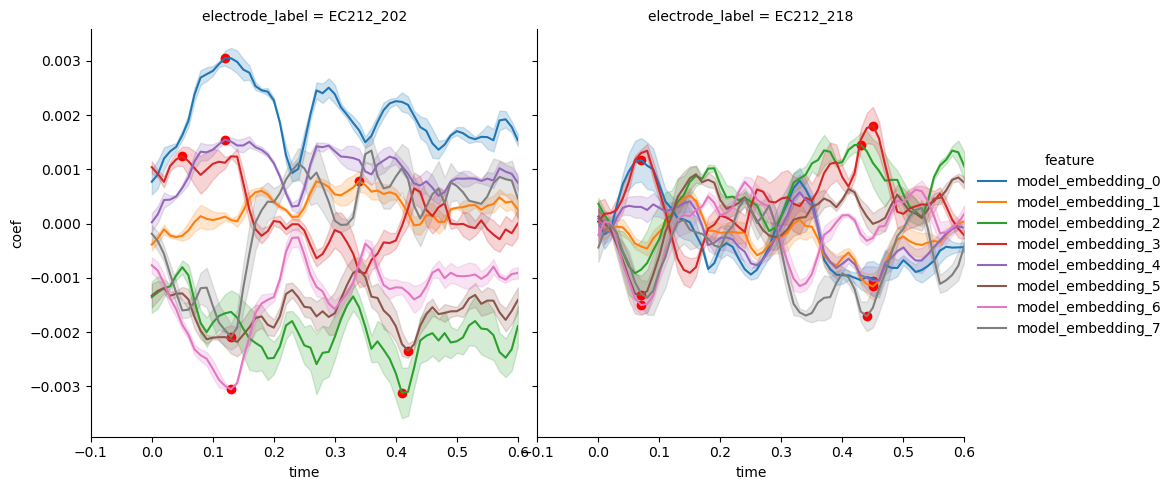

In [27]:
# plot raw activations
hue_order = sorted(set(feature for feature in coef_df.feature if feature.startswith("model_embedding")))
col_order = biphone_recon_dominant
g = sns.relplot(data=coef_df[coef_df.electrode_label.isin(biphone_recon_dominant) &
                             coef_df.feature.isin(hue_order)],
                col="electrode_label", col_wrap=2, col_order=col_order,
                x="time", y="coef",
                hue="feature", hue_order=hue_order,
                kind="line", errorbar="se", facet_kws=dict(sharex=False))

max_points = {}
for (row, col, hue), facet_data in g.facet_data():
    ax = g.facet_axis(row, col)
    ax.set_xlim((-0.1, 0.6))

    for feature, feature_rows in facet_data.groupby("feature"):
        facet_means = feature_rows.groupby("time").coef.mean()
        max_point = np.abs(facet_means).idxmax()
        ax.scatter(max_point, facet_means.loc[max_point], color="red")

        output_dim = feature_rows.output_dim.iloc[0]
        max_points[output_dim, feature] = max_point

## Understand the PCs

In [28]:
all_trajectories_pca.shape

(200190, 4)

In [136]:
for traj_idx in all_trajectories_pca[:, 1].argsort()[:40]:
    label_idx, instance_idx = all_trajectories_src[traj_idx]
    print(state_space_spec.labels[label_idx], instance_idx, all_trajectories_pca[traj_idx, 1])

('R', 'IY') 803 -1.6345783072640063
('IY', '#') 3012 -1.6024326137378293
('R', 'AE') 250 -1.5728898272506635
('L', '#') 701 -1.5690909475926413
('R', 'IY') 512 -1.5506762388592716
('R', 'IY') 777 -1.5468764758119586
('AH', 'L') 247 -1.5466031433104745
('IY', '#') 49 -1.5441646035712662
('R', 'IY') 40 -1.5432722052021561
('IY', '#') 2924 -1.5292179244686535
('R', 'IY') 50 -1.5237917093664504
('ER', 'IY') 1 -1.5208511699982128
('IY', '#') 1991 -1.5191648115983791
('R', 'IY') 658 -1.5111988569713337
('R', 'AE') 251 -1.5066930173405821
('IY', '#') 164 -1.4993227556585347
('R', 'IY') 608 -1.4975286908467262
('R', 'IY') 344 -1.4963549428942269
('R', 'IY') 53 -1.4939073937482883
('L', '#') 730 -1.4913236425479173
('ER', '#') 1031 -1.4911115011576994
('IY', '#') 174 -1.4871052719720321
('ER', '#') 573 -1.4863226209589315
('AO', 'R') 399 -1.4858088778790992
('R', 'IY') 758 -1.4840355682236928
('AO', 'R') 55 -1.4833566565047764
('R', 'EY') 224 -1.4825842541678458
('R', 'AW') 19 -1.48164684401419

In [1]:
for traj_idx in all_trajectories_pca[:, 1].argsort()[-20:]:
    label_idx, instance_idx = all_trajectories_src[traj_idx]
    print(state_space_spec.labels[label_idx], instance_idx, all_trajectories_pca[traj_idx, 1])

NameError: name 'all_trajectories_pca' is not defined

In [31]:
instance_df = pd.DataFrame(
    [(state_space_spec.labels[label_idx], instance_idx)
     for label_idx, instance_idx in all_trajectories_src],
    columns=["label", "instance_idx"]).set_index(["label", "instance_idx"])

In [32]:
instance_df = pd.merge(
    pd.DataFrame(all_trajectories_pca,
        columns=[f"pca_{dim + 1}" for dim in range(pca.n_components_)],
        index=pd.MultiIndex.from_tuples([(state_space_spec.labels[label_idx], instance_idx) for label_idx, instance_idx in all_trajectories_src], names=["label", "instance_idx"])),
    instance_df,
    left_index=True, right_index=True, how="left", validate="one_to_one")
instance_df["label_str"] = instance_df.index.get_level_values("label").map(lambda x: " ".join(x))

In [33]:
instance_df["has_boundary"] = instance_df.label_str.str.contains("#")
instance_df["has_a"] = instance_df.label_str.str.contains("A")

In [131]:
sonorantish = ['AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'W', 
                'AE', 'Y', 'AO', 'AA', 'OW', 'L', 'OY',
                'AW', 'AY', 'UW', 'R',
                "M", "N", "NG", "B", "P", "F", "V", "DH"]
sonorantish_re = "|".join(f"\\b{phone}\\b" for phone in sonorantish)
instance_df["sonorantish_count"] = instance_df.label_str.str.count(sonorantish_re)

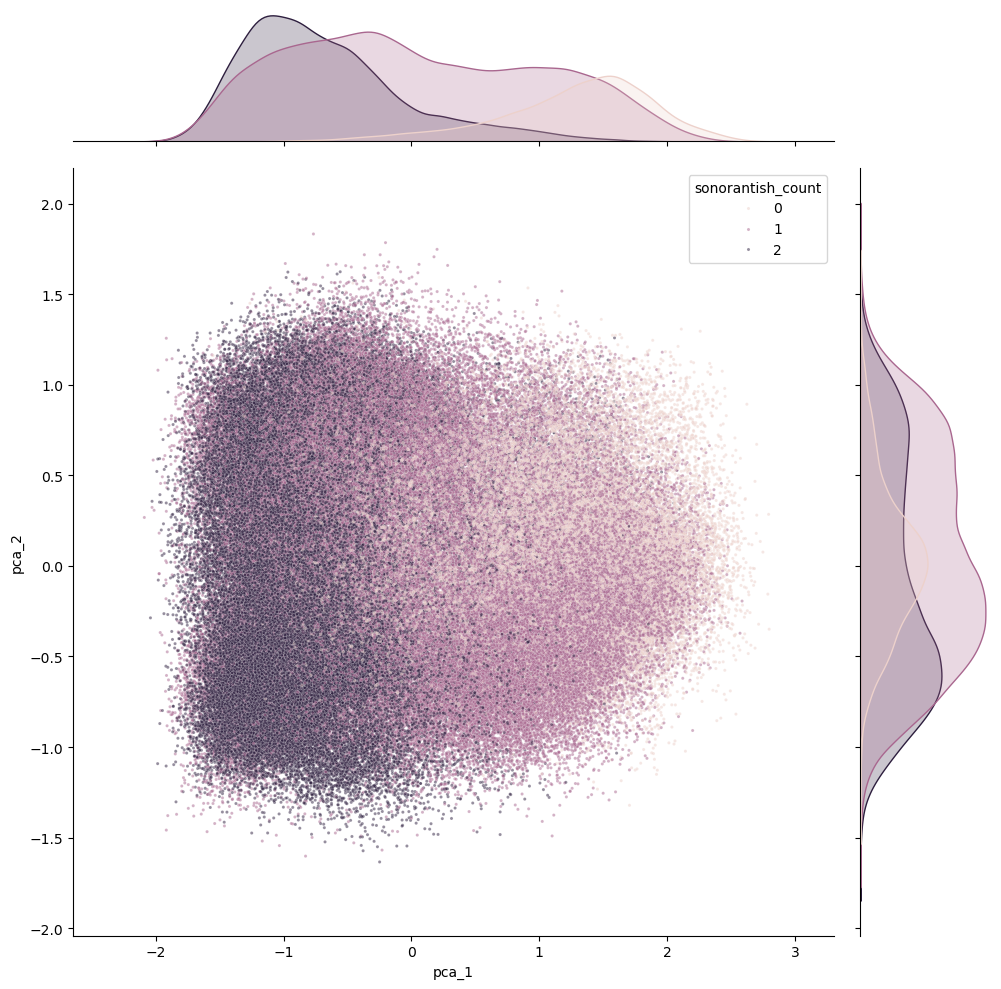

In [118]:
sns.jointplot(data=instance_df, x="pca_1", y="pca_2", hue="sonorantish_count",
              height=10, joint_kws=dict(alpha=0.5, s=5))

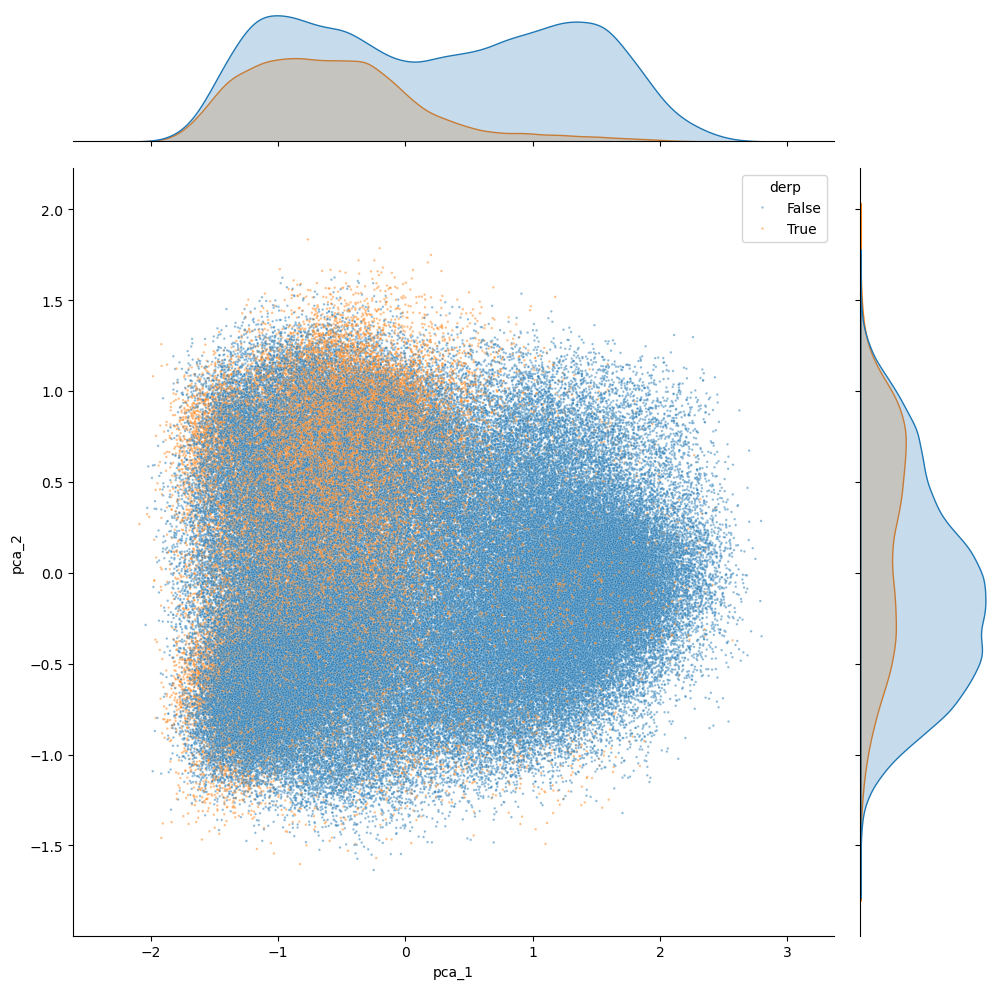

In [119]:
sns.jointplot(data=instance_df.assign(derp=instance_df.has_boundary & (instance_df.sonorantish_count == 1)), x="pca_1", y="pca_2", hue="derp",
              height=10, joint_kws=dict(alpha=0.5, s=3))

In [132]:
instance_df_means = instance_df.groupby("label_str")[["pca_1", "pca_2", "pca_3", "pca_4"]].agg(["mean", "std", "count"])
instance_df_means.columns = instance_df_means.columns.to_flat_index().map(lambda x: "_".join(x))
instance_df_means = instance_df_means.reset_index()
# ignore infrequent
instance_df_means = instance_df_means[instance_df_means.pca_1_count >= 20]

In [166]:
instance_df_means["has_boundary"] = instance_df_means.label_str.str.contains("#")
instance_df_means["sonorantish_count"] = instance_df_means.label_str.str.count(sonorantish_re)
instance_df_means["has_nasal"] = instance_df_means.label_str.str.contains(r"\b(N|NG|M)\b", regex=True)
instance_df_means["has_initial_nasal"] = instance_df_means.label_str.str.startswith(("N", "NG", "# N", "M", "# M"))
instance_df_means["derp"] = (instance_df_means.has_boundary & (instance_df_means.sonorantish_count == 1)) | (instance_df_means.sonorantish_count == 2)
instance_df_means["derp2"] = (instance_df_means.sonorantish_count == 2)
instance_df_means["pca2_hyp"] = instance_df_means.has_initial_nasal | (instance_df_means.label_str.str.startswith(("DH", "# DH")))

/tmp/ipykernel_695744/2012706123.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  instance_df_means["has_nasal"] = instance_df_means.label_str.str.contains(r"\b(N|NG|M)\b", regex=True)


<Axes: xlabel='pca_1_mean', ylabel='pca_2_mean'>

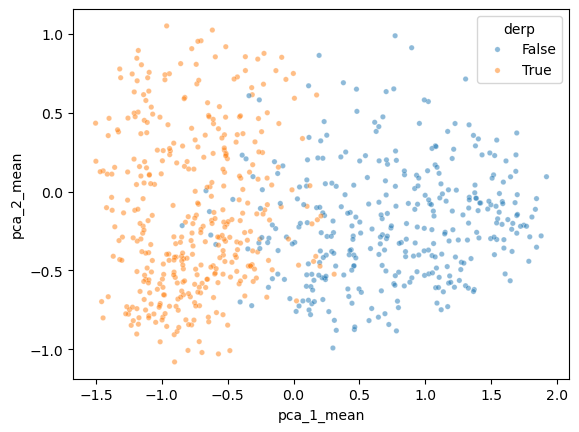

In [134]:
sns.scatterplot(data=instance_df_means, x="pca_1_mean", y="pca_2_mean", hue="derp", alpha=0.5, s=15)

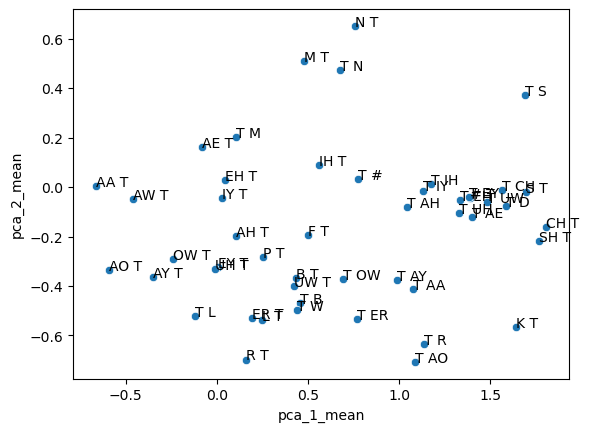

In [126]:
plot_phoneme = "T"
ax = sns.scatterplot(data=instance_df_means[instance_df_means.label_str.str.contains(r"\b" + plot_phoneme + r"\b", regex=True)], x="pca_1_mean", y="pca_2_mean")
for label, row in instance_df_means[instance_df_means.label_str.str.contains(r"\b" + plot_phoneme + r"\b", regex=True)].iterrows():
    ax.text(row.pca_1_mean, row.pca_2_mean, row.label_str)

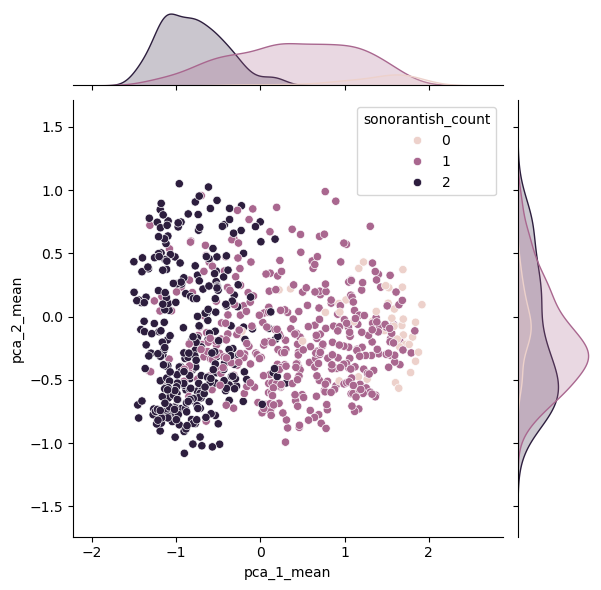

In [110]:
sns.jointplot(data=instance_df_means,
              x="pca_1_mean", y="pca_2_mean", hue="sonorantish_count")

In [141]:
instance_df_means.sort_values("pca_2_mean").head(20)

label_str  pca_1_mean  pca_1_std  pca_1_count  pca_2_mean  pca_2_std  \
352      ER EY   -0.903277   0.372470           64   -1.079995   0.133925   
873       R OY   -0.570359   0.536005           30   -1.029167   0.165835   
850       R AE   -0.695249   0.407622          297   -1.020288   0.208591   
852       R AO   -0.483649   0.348899          117   -1.008229   0.196270   
861       R EY   -0.801513   0.398021          312   -1.007122   0.211486   
614       K OY    0.298491   0.174745           33   -0.991708   0.108364   
853       R AW   -1.012628   0.261460           58   -0.952368   0.197525   
350      ER EH   -0.716161   0.372938           27   -0.951131   0.179664   
849       R AA   -0.906008   0.345477          288   -0.907368   0.167964   
629       L AE   -1.190510   0.298888          270   -0.903017   0.229801   
854       R AY   -0.884089   0.400723          269   -0.886936   0.178292   
868        R K    0.780645   0.277768           64   -0.883273   0.158872   
141       AO K    0.324133   0.798006           39   -0.879614   0.176798   
359       ER K    0.461529   0.562935          143   -0.874868   0.242582   
872       R OW   -0.871305   0.344950          243   -0.861292   0.194795   
596       K AO    0.464438   0.279097          182   -0.858353   0.148262   
639       L ER   -0.963021   0.265801          167   -0.854864   0.169963   
1101      W AA   -1.232370   0.355569          134   -0.847922   0.218153   
1056      UW L   -0.500270   0.641477           84   -0.846869   0.277730   
357      ER IY   -0.774046   0.438096          132   -0.845502   0.261037   

      pca_2_count  pca_3_mean  pca_3_std  pca_3_count  pca_4_mean  pca_4_std  \
352            64   -0.192078   0.303761           64   -0.011947   0.006339   
873            30   -0.503587   0.209592           30   -0.016661   0.009369   
850           297   -0.374625   0.221881          297   -0.008156   0.007961   
852           117   -0.425609   0.268262          117   -0.012859   0.006898   
861           312   -0.304127   0.283271          312   -0.004507   0.008668   
614            33   -0.508801   0.107221           33    0.002207   0.007325   
853            58   -0.280327   0.271321           58   -0.007535   0.007123   
350            27   -0.221797   0.365049           27   -0.010182   0.007938   
849           288   -0.122562   0.308410          288   -0.009945   0.007520   
629           270   -0.209463   0.215795          270   -0.003955   0.007195   
854           269   -0.246727   0.250419          269   -0.010453   0.008482   
868            64   -0.333811   0.086982           64    0.011340   0.007196   
141            39   -0.416818   0.136330           39    0.000440   0.008668   
359           143   -0.315984   0.153242          143    0.009497   0.008603   
872           243   -0.217211   0.303677          243   -0.005646   0.008231   
596           182   -0.520432   0.111231          182   -0.001658   0.011627   
639           167   -0.259984   0.166387          167   -0.008104   0.009876   
1101          134   -0.363224   0.197853          134   -0.003311   0.007088   
1056           84   -0.369421   0.410168           84   -0.004444   0.009189   
357           132   -0.207758   0.307345          132   -0.009429   0.007218   

      pca_4_count  has_boundary  sonorantish_count   derp  derp2  
352            64         False                  2   True   True  
873            30         False                  2   True   True  
850           297         False                  2   True   True  
852           117         False                  2   True   True  
861           312         False                  2   True   True  
614            33         False                  1  False  False  
853            58         False                  2   True   True  
350            27         False                  2   True   True  
849           288         False                  2   True   True  
629           270         False     

In [142]:
instance_df_means.sort_values("pca_2_mean").tail(20)

label_str  pca_1_mean  pca_1_std  pca_1_count  pca_2_mean  pca_2_std  \
669      M AE   -1.319646   0.268318          167    0.777597   0.186524   
705      N AW   -1.154802   0.274350           71    0.804230   0.217573   
703      N AH   -0.738986   0.481975          280    0.806869   0.364006   
733      N UW   -0.857128   0.385191          103    0.811471   0.185527   
700       N #   -0.271878   0.618095         3899    0.840018   0.344609   
701      N AA   -1.189874   0.270236          224    0.845517   0.222874   
739      NG #   -0.090098   0.499693         1181    0.851352   0.383516   
734       N V   -0.593948   0.370574           40    0.854617   0.159317   
717      N IH   -0.365976   0.494751          623    0.855381   0.320253   
709       N D    0.193797   0.460712          675    0.863560   0.281917   
304     DH IY   -0.224382   0.306098          350    0.876376   0.215508   
706      N AY   -1.178436   0.302150          100    0.894833   0.169028   
711      N EH   -0.773031   0.421936          177    0.906312   0.270805   
737       N Z    0.896151   0.479888          422    0.912198   0.191427   
736       N Y   -0.514704   0.376082           61    0.918666   0.225059   
713      N EY   -0.726254   0.474797           79    0.952690   0.345121   
22        # N   -0.702376   0.377873         1177    0.956465   0.242842   
760      NG Z    0.770755   0.337704           43    0.988168   0.193304   
718      N IY   -0.616545   0.303953          428    1.024155   0.240645   
702      N AE   -0.963364   0.372073           59    1.050488   0.200357   

     pca_2_count  pca_3_mean  pca_3_std  pca_3_count  pca_4_mean  pca_4_std  \
669          167   -0.205149   0.120464          167   -0.013556   0.008084   
705           71   -0.469729   0.150829           71   -0.007008   0.007324   
703          280   -0.363002   0.149788          280   -0.014869   0.010116   
733          103   -0.456287   0.105740          103   -0.003215   0.007712   
700         3899   -0.220420   0.213729         3899   -0.012357   0.012821   
701          224   -0.534818   0.111227          224   -0.011336   0.007043   
739         1181   -0.390093   0.230960         1181   -0.006268   0.010132   
734           40    0.328153   0.197833           40   -0.020601   0.008071   
717          623   -0.334042   0.173867          623   -0.010454   0.010970   
709          675   -0.240630   0.191810          675   -0.021818   0.010189   
304          350    0.208115   0.217301          350    0.023230   0.012589   
706          100   -0.569364   0.116456          100   -0.013567   0.005487   
711          177   -0.392139   0.124349          177   -0.009873   0.010746   
737          422    0.035230   0.122978          422   -0.019162   0.008199   
736           61   -0.540342   0.131525           61   -0.020069   0.010175   
713           79   -0.464018   0.115767           79   -0.009524   0.009147   
22          1177   -0.322651   0.148136         1177   -0.005478   0.010872   
760           43   -0.096079   0.134820           43   -0.012833   0.007158   
718          428   -0.354732   0.140945          428   -0.005791   0.010204   
702           59   -0.501491   0.110535           59   -0.011749   0.007335   

     pca_4_count  has_boundary  sonorantish_count   derp  derp2  
669          167         False                  2   True   True  
705           71         False                  2   True   True  
703          280         False                  2   True   True  
733          103         False                  2   True   True  
700         3899          True                  1   True  False  
701          224         False                  2   True   True  
739         1181          True                  1   True  False  
734           40         False                  2   True   True  
717          623         False                  2   True   True  
709          675         False                  1  False  False  
304          350     

<Axes: xlabel='pca_1_mean', ylabel='pca_2_mean'>

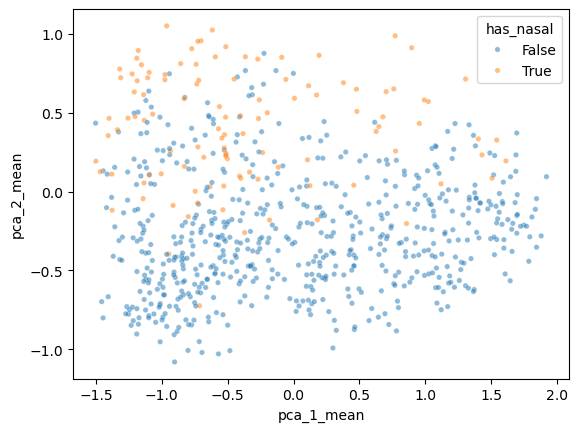

In [148]:
sns.scatterplot(data=instance_df_means, x="pca_1_mean", y="pca_2_mean", hue="has_nasal", alpha=0.5, s=15)

In [149]:
instance_df_means[instance_df_means.has_nasal & (instance_df_means.pca_2_mean < -0.5)]

label_str  pca_1_mean  pca_1_std  pca_1_count  pca_2_mean  pca_2_std  \
806      OY N   -0.713974   0.550225           75   -0.723582   0.245912   

     pca_2_count  pca_3_mean  pca_3_std  pca_3_count  pca_4_mean  pca_4_std  \
806           75   -0.055952   0.431085           75   -0.009654   0.007711   

     pca_4_count  has_boundary  sonorantish_count  derp  derp2  has_nasal  
806           75         False                  2  True   True       True

In [150]:
instance_df_means[instance_df_means.has_nasal & (instance_df_means.pca_2_mean.between(-0.5, 0))]

label_str  pca_1_mean  pca_1_std  pca_1_count  pca_2_mean  pca_2_std  \
55        AA M   -0.536614   0.692273          181   -0.115153   0.501906   
145      AO NG   -0.947104   0.448141          121   -0.395934   0.217916   
168       AW N   -0.182478   0.787683          236   -0.180280   0.403949   
193       AY M    0.180723   0.580878          143   -0.178428   0.223483   
194       AY N   -0.727876   0.832022          205   -0.072581   0.492817   
361       ER M   -0.914755   0.517526          186   -0.087718   0.304949   
362       ER N   -0.371640   0.643976          188   -0.259820   0.382936   
457        G N    0.857094   0.373563           49   -0.202613   0.284708   
870        R M   -1.142226   0.266427          187   -0.044824   0.247952   
871        R N   -0.799523   0.380254           90   -0.158967   0.308402   
1025      UH M   -1.376886   0.421199           23   -0.118467   0.293838   

      pca_2_count  pca_3_mean  pca_3_std  pca_3_count  pca_4_mean  pca_4_std  \
55            181   -0.308349   0.244779          181   -0.027722   0.012326   
145           121   -0.456641   0.118991          121   -0.003110   0.007593   
168           236   -0.368214   0.420951          236   -0.021550   0.011908   
193           143   -0.465759   0.176282          143   -0.033557   0.010830   
194           205   -0.223569   0.411700          205   -0.017632   0.011589   
361           186    0.240573   0.332800          186   -0.021196   0.010960   
362           188   -0.241380   0.325119          188   -0.007421   0.009777   
457            49   -0.671202   0.101652           49    0.019163   0.011406   
870           187    0.071457   0.247771          187   -0.021291   0.010249   
871            90   -0.323767   0.098542           90   -0.009304   0.009778   
1025           23   -0.119661   0.190485           23   -0.015027   0.009160   

      pca_4_count  has_boundary  sonorantish_count   derp  derp2  has_nasal  
55            181         False                  2   True   True       True  
145           121         False                  2   True   True       True  
168           236         False                  2   True   True       True  
193           143         False                  2   True   True       True  
194           205         False                  2   True   True       True  
361           186         False                  2   True   True       True  
362           188         False                  2   True   True       True  
457            49         False                  1  False  False       True  
870           187         False                  2   True   True       True  
871            90         False                  2   True   True       True  
1025           23         False                  2   True   True       True

In [170]:
instance_df_means[~instance_df_means.pca2_hyp & (instance_df_means.pca_2_mean > 0.5)].sort_values("pca_2_mean")

label_str  pca_1_mean  pca_1_std  pca_1_count  pca_2_mean  pca_2_std  \
327       EH N   -0.199511   0.832433          874    0.500004   0.536774   
472      HH AE   -1.180077   0.413548          329    0.503950   0.264874   
15        # HH   -1.080034   0.519095         2099    0.535538   0.285073   
514       IH M   -0.562909   0.689618          535    0.538721   0.433663   
10        # EH   -0.652806   0.343951          847    0.563423   0.308070   
491       HH Y   -1.121227   0.723371           39    0.577748   0.307668   
1156       Z N    0.992346   0.306593           47    0.581178   0.231154   
516      IH NG    0.006460   0.702719          892    0.591675   0.466066   
1         # AE   -0.825400   0.302183          693    0.597056   0.259916   
94        AE Z   -0.338487   0.376774           79    0.607937   0.223682   
553      IY NG    0.174702   0.703483          271    0.612512   0.457662   
16        # IH   -0.313427   0.431748         3883    0.614319   0.299169   
481      HH IY   -1.098951   0.399629          325    0.637028   0.199170   
1155       Z M    0.477345   0.331304           24    0.649468   0.259634   
515       IH N   -0.058306   0.760405         3181    0.711383   0.403331   
1088       V N   -0.451329   0.336249           43    0.713701   0.165944   
480      HH IH   -0.942617   0.446642          370    0.747416   0.269306   

      pca_2_count  pca_3_mean  pca_3_std  pca_3_count  pca_4_mean  pca_4_std  \
327           874   -0.207116   0.348856          874   -0.008038   0.015056   
472           329   -0.390271   0.163198          329    0.008675   0.008931   
15           2099   -0.328141   0.199115         2099    0.013168   0.010963   
514           535   -0.037062   0.258024          535   -0.016092   0.014096   
10            847   -0.283347   0.147002          847    0.011643   0.010330   
491            39   -0.461744   0.129389           39    0.011841   0.007737   
1156           47    0.129212   0.120781           47   -0.013751   0.008822   
516           892   -0.238851   0.357524          892   -0.004803   0.010547   
1             693   -0.353921   0.150521          693    0.008707   0.009158   
94             79   -0.171161   0.149301           79    0.004404   0.008890   
553           271   -0.321188   0.331054          271   -0.005748   0.009427   
16           3883   -0.167892   0.202977         3883    0.016038   0.012795   
481           325   -0.391581   0.154770          325    0.008923   0.008805   
1155           24    0.242870   0.166331           24   -0.030450   0.008431   
515          3181   -0.216338   0.264834         3181   -0.005869   0.014314   
1088           43    0.476143   0.149027           43    0.001401   0.017868   
480           370   -0.325511   0.164190          370    0.015394   0.009458   

      pca_4_count  has_boundary  sonorantish_count   derp  derp2  has_nasal  \
327           874         False                  2   True   True       True   
472           329         False                  2   True   True      False   
15           2099          True                  1   True  False      False   
514           535         False                  2   True   True       True   
10            847          True                  1   True  False      False   
491            39         False                  2   True   True      False   
1156           47         False                  1  False  False       True   
516           892         False                  2   True   True       True   
1             693          True                  1   True  False      False   
94             79         False                  1  False  False      False   
553           271         False                  2   True   True       True   
16           3883          True                  1   True  False      False   
481           325         False                  2   True   True      False   
1155           24         False                  1  False  False       

In [173]:
instance_df_means[instance_df_means.pca2_hyp & (instance_df_means.pca_2_mean < 0.5)].sort_values("pca_2_mean")

label_str  pca_1_mean  pca_1_std  pca_1_count  pca_2_mean  pca_2_std  \
678      M ER   -1.094879   0.268773          143    0.104451   0.224377   
721       N L   -1.004406   0.602016          210    0.112781   0.375757   
684       M L   -1.467647   0.233797           52    0.126148   0.223880   
748      NG L   -0.828184   0.255900           21    0.159864   0.360336   
671      M AO   -1.500480   0.234191          159    0.192412   0.218572   
688       M P   -0.502322   0.279917          332    0.208508   0.211482   
708      N CH    1.430562   0.347511           54    0.232800   0.245877   
712      N ER   -0.726120   0.375868          212    0.282928   0.380206   
729      N SH    1.541841   0.350361           53    0.326563   0.204303   
726       N P   -0.543828   0.145555           26    0.339653   0.192148   
668      M AA   -1.406779   0.260365          110    0.354944   0.233361   
720       N K    0.626865   0.299878           47    0.381467   0.318246   
686      M OW   -1.336073   0.234931          138    0.391810   0.188752   
680       M F   -0.570195   0.177011           20    0.398657   0.233464   
747      NG K    0.646954   0.336999          155    0.411993   0.327913   
294      DH #   -0.111744   0.519899           87    0.431570   0.240562   
704      N AO   -1.133171   0.406020           43    0.451632   0.355318   
301     DH ER   -0.610186   0.301955          213    0.458277   0.255256   
714       N F   -0.266416   0.323167           70    0.463242   0.210662   
673      M AY   -1.400566   0.232911          220    0.464554   0.177972   
695      M UW   -1.257032   0.272639           90    0.465945   0.215435   
308     DH OW   -0.641747   0.306967           54    0.474579   0.316958   
725      N OY   -1.202432   0.164674           28    0.474817   0.302927   
674       M B   -1.069280   0.235478          153    0.491065   0.189116   

     pca_2_count  pca_3_mean  pca_3_std  pca_3_count  pca_4_mean  pca_4_std  \
678          143   -0.078431   0.140393          143   -0.013720   0.011429   
721          210   -0.383646   0.124401          210   -0.015945   0.007555   
684           52   -0.134439   0.169844           52   -0.022051   0.010021   
748           21   -0.561814   0.141858           21   -0.008991   0.006789   
671          159   -0.240082   0.139232          159   -0.011858   0.007717   
688          332    0.826641   0.205666          332   -0.024367   0.010965   
708           54   -0.063502   0.114578           54   -0.013490   0.011624   
712          212   -0.383030   0.142962          212   -0.016057   0.009926   
729           53   -0.108043   0.132794           53   -0.016658   0.011529   
726           26    0.596446   0.170738           26   -0.020200   0.006518   
668          110   -0.215097   0.128957          110   -0.012044   0.007500   
720           47   -0.453954   0.160675           47   -0.001567   0.009927   
686          138   -0.159937   0.109103          138   -0.011069   0.007854   
680           20    1.037086   0.181733           20   -0.023183   0.009716   
747          155   -0.253135   0.265347          155    0.000809   0.011336   
294           87    0.573698   0.289370           87    0.018426   0.010798   
704           43   -0.569986   0.127911           43   -0.008554   0.007056   
301          213    0.428905   0.237840          213    0.024277   0.012740   
714           70    0.814015   0.184711           70   -0.022457   0.008393   
673          220   -0.226348   0.123244          220   -0.011941   0.008256   
695           90   -0.149531   0.101575           90   -0.008185   0.010065   
308           54    0.333782   0.155556           54    0.017084   0.012276   
725           28   -0.492880   0.087750           28   -0.011019   0.005278   
674          153    0.618648   0.252783          153   -0.029505   0.007773   

     pca_4_count  has_boundary  sonorantish_count   derp  derp2  has_nasal  \
678          143         False                  2

<Axes: xlabel='pca_1_mean', ylabel='pca_2_mean'>

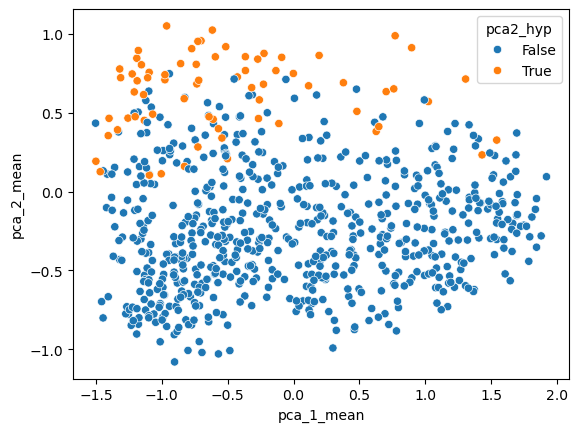

In [167]:
sns.scatterplot(data=instance_df_means, x="pca_1_mean", y="pca_2_mean", hue="pca2_hyp")

In [64]:
instance_df.groupby(["label"]).pca_1.agg(["count", "mean", "std"]).dropna().sort_values("mean").head(50)

count      mean       std
label                              
(Z, T)        4 -1.552457  0.298789
(D, CH)       3 -1.440968  0.275847
(D, S)       38 -1.399515  0.275531
(SH, NG)      2 -1.345411  0.044621
(JH, D)      41 -1.334195  0.251414
(T, S)      744 -1.323924  0.293971
(TH, S)       7 -1.322895  0.218272
(SH, DH)      2 -1.309974  0.301702
(ZH, D)       7 -1.301054  0.155641
(ZH, T)       4 -1.291046  0.405190
(SH, D)       2 -1.287465  0.498415
(T, SH)      15 -1.285278  0.255710
(S, CH)      30 -1.280497  0.182904
(CH, T)      27 -1.275230  0.233523
(N, S)      499 -1.255149  0.257699
(JH, T)      11 -1.253134  0.257257
(SH, CH)     20 -1.247480  0.292750
(JH, #)     383 -1.245979  0.326846
(S, #)     3016 -1.229484  0.350951
(S, D)        3 -1.228854  0.267897
(NG, ZH)      2 -1.224097  0.046326
(G, S)       22 -1.223646  0.222268
(Z, D)       97 -1.222900  0.332602
(D, Z)      173 -1.210705  0.321908
(#, SH)     613 -1.201134  0.289235
(SH, IH)    434 -1.198808  0.308701
(S, SH)       6 -1.196843  0.147504
(N, CH)      54 -1.194929  0.275074
(JH, N)      25 -1.190459  0.212909
(N, SH)      53 -1.189824  0.220301
(SH, N)     253 -1.174875  0.223254
(SH, #)     251 -1.166344  0.310431
(S, T)     1378 -1.166018  0.275252
(NG, Z)      43 -1.165268  0.155044
(N, Z)      422 -1.159352  0.271722
(UW, CH)      7 -1.157222  0.090556
(G, TH)       2 -1.156247  0.037105
(K, SH)      94 -1.151078  0.278096
(CH, #)     429 -1.150242  0.298465
(SH, T)      64 -1.149448  0.274929
(NG, T)       2 -1.148447  0.267627
(K, TH)       7 -1.147137  0.197292
(T, CH)      21 -1.146544  0.258102
(S, G)       12 -1.126919  0.203284
(G, ZH)       5 -1.120401  0.168704
(N, JH)     133 -1.118616  0.226488
(CH, N)       8 -1.116018  0.227558
(D, DH)       4 -1.094909  0.505693
(S, NG)       3 -1.090939  0.044530
(ZH, IH)     26 -1.082090  0.362049

In [65]:
instance_df.groupby(["label"]).pca_1.agg(["count", "mean", "std"]).dropna().sort_values("mean").tail(50)

count      mean       std
label                              
(V, AA)      29  1.482681  0.206599
(AW, #)     225  1.484934  0.374656
(IH, AO)      4  1.488473  0.250483
(AA, Y)       3  1.495973  0.477763
(AW, EH)     13  1.496987  0.220593
(UW, AW)      3  1.500073  0.299741
(L, W)       34  1.508641  0.305370
(AA, W)       6  1.513974  0.243198
(L, AY)     308  1.515261  0.327052
(R, AO)     117  1.520781  0.280806
(EY, AO)      7  1.522022  0.137237
(AY, ER)    133  1.523784  0.225162
(AE, L)     195  1.535170  0.291963
(AW, B)       2  1.537029  0.306541
(#, AA)     591  1.537090  0.338979
(W, AY)     179  1.538267  0.305424
(OW, R)       3  1.544651  0.215420
(W, AO)     189  1.561232  0.269303
(#, AW)     209  1.561727  0.289306
(AA, V)      34  1.567441  0.235303
(ER, AA)     24  1.570290  0.164042
(#, AO)     713  1.570351  0.360966
(AO, W)      18  1.577131  0.167920
(AA, ER)     26  1.581338  0.224313
(UW, AA)      4  1.584455  0.185396
(L, AO)     187  1.588151  0.244368
(AO, #)     172  1.595684  0.401327
(R, AA)     288  1.602196  0.289139
(AY, OW)     14  1.602628  0.379846
(V, AW)       2  1.607043  0.166491
(W, AA)     134  1.607364  0.359258
(AW, L)      17  1.615571  0.238405
(ER, AY)     24  1.627065  0.215906
(AW, W)       6  1.635160  0.226946
(OY, L)      44  1.642041  0.280765
(AY, AH)     24  1.664720  0.322760
(L, AA)     188  1.678866  0.230553
(AO, L)     401  1.699677  0.248780
(OY, AH)      2  1.702522  0.231611
(L, AW)     102  1.706106  0.251989
(AY, L)     124  1.725449  0.306563
(AA, L)     253  1.746482  0.246523
(AY, AO)     13  1.777340  0.257552
(AA, AH)      2  1.790195  0.239613
(ER, AO)     15  1.794097  0.155406
(OW, AA)      5  1.814921  0.208966
(AH, AO)      3  1.818419  0.130924
(OW, AO)     17  1.890895  0.208585
(AY, AA)     10  1.950252  0.270459
(AA, AO)      2  2.126721  0.312626

In [32]:
instance_df.sort_values("pca_1").head(20)

pca_1     pca_2     pca_3     pca_4
label  instance_idx                                        
(S, #) 1956         -2.144052 -0.830935  0.193138  0.013694
       1478         -2.032190 -0.542292  0.217485  0.015950
(Z, #) 92           -2.030790 -0.885503  0.161288  0.010845
(S, #) 2718         -2.026911 -0.932514  0.179368  0.000983
(Z, #) 1009         -2.019561 -0.653941  0.054131  0.009238
       44           -2.017106 -0.816729  0.101175  0.001563
(S, #) 1793         -2.014595 -0.925540  0.285459 -0.004455
       444          -1.995507 -0.475127  0.149994  0.001065
       3011         -1.977325 -0.926995  0.271934  0.001975
       1916         -1.976361 -0.964832  0.250014  0.003576
       2521         -1.955914 -0.940731  0.197511  0.004059
       88           -1.946054 -0.847063  0.193412  0.000058
(Z, #) 267          -1.943069 -0.840334  0.169082  0.017906
(S, #) 1663         -1.939898 -0.767379  0.116138  0.006051
(T, S) 474          -1.936507 -0.549027  0.262213  0.016954
(T, #) 613          -1.936461 -0.762528  0.120370  0.007759
(S, #) 1505         -1.933582 -0.828348  0.204721  0.007306
       2304         -1.933249 -0.930741  0.145732  0.012310
       1606         -1.931661 -0.949974  0.193360  0.015446
(Z, T) 0            -1.927542 -0.766895  0.030355  0.007287

In [33]:
instance_df.sort_values("pca_1").tail(20)

pca_1     pca_2     pca_3     pca_4
label    instance_idx                                        
(#, AO)  577           2.331555 -0.215784  0.073127 -0.008387
(W, AA)  118           2.334951 -0.173607  0.069807 -0.013315
(AO, #)  5             2.337752  0.029507 -0.108683 -0.004811
(AW, #)  168           2.341712 -0.066150  0.118269 -0.015121
(AH, L)  284           2.342209 -0.201465 -0.016261 -0.009279
(AY, #)  291           2.345666  0.220385  0.010928 -0.021451
(AA, AO) 0             2.347781 -0.178500  0.089607 -0.017622
(AA, L)  93            2.359901  0.017966 -0.064501 -0.005408
(#, AO)  292           2.360734 -0.247142  0.168483 -0.012712
(#, AA)  305           2.383575 -0.243129  0.124602 -0.010427
(R, AA)  141           2.386945 -0.447723  0.080603 -0.001194
(AO, #)  127           2.392321 -0.129999  0.007989 -0.007751
(AY, #)  282           2.401832  0.022289 -0.000966 -0.016440
(#, AO)  508           2.402033 -0.222217  0.080240 -0.010905
(AO, #)  140           2.407862 -0.256615  0.034471 -0.006115
         60            2.419737 -0.034420  0.162383 -0.017331
(#, AA)  395           2.423238 -0.323444  0.116344 -0.024155
(AO, #)  21            2.429767  0.055715  0.061026 -0.025819
(AA, L)  69            2.443668 -0.120307  0.047384 -0.013168
         36            2.473032 -0.145994  0.051527 -0.014787

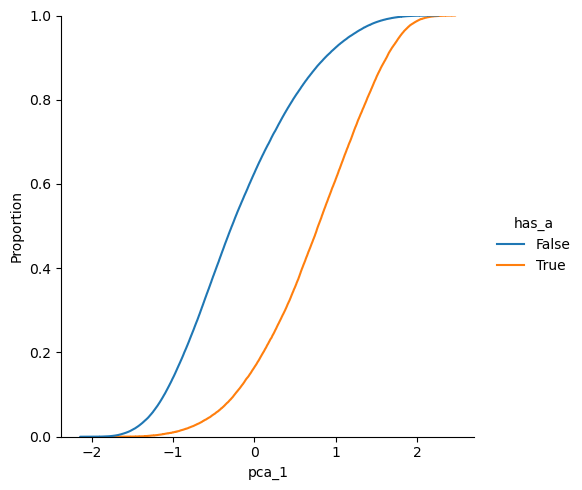

In [49]:
sns.displot(data=instance_df.assign(has_a=instance_df.label_str.str.contains("A")),
            x="pca_1", hue="has_a", kind="ecdf")

In [119]:
vowels = {'AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'AE',
          'AO', 'AA', 'OW', 'OY', 'AW', 'AY', 'UW'}
instance_df["has_vowel"] = instance_df.groupby(["label", "instance_idx"]).apply(lambda xs: bool(set(xs.name[0]) & vowels))
# instance_metadata["classifier_label"] = instance_metadata.onset_phoneme.isin(pca_1_onsets)
# cmap = sns.color_palette("tab10", n_colors=10)
# scatter_colors = [cmap[int(instance_metadata.loc[(state_space_spec.labels[label_idx], instance_idx), "classifier_label"].item())]
#                   for label_idx, instance_idx in all_trajectories_src]

In [110]:
instance_df

pca_1     pca_2     pca_3     pca_4  has_vowel
label    instance_idx                                                   
(#, AA)  0             1.163460 -0.117412 -0.002953 -0.016334       True
         1             1.889161 -0.379648  0.140857 -0.025684       True
         2             1.262562  0.630296  0.660571 -0.006404       True
         3             1.189161  0.237057 -0.318570 -0.003920       True
         4             1.696788 -0.097771  0.126078 -0.012591       True
...                         ...       ...       ...       ...        ...
(ZH, UW) 13           -0.165072  0.128852 -0.326310 -0.002416       True
(ZH, W)  0             0.224599 -0.228616 -0.151824  0.007952      False
         1            -0.440599 -0.251556 -0.119367 -0.001151      False
         2            -1.014602 -0.479195 -0.062535 -0.008267      False
(ZH, Y)  0            -0.769677 -0.199989 -0.128778 -0.002297      False

[200190 rows x 5 columns]

<Axes: xlabel='pca_1', ylabel='pca_2'>

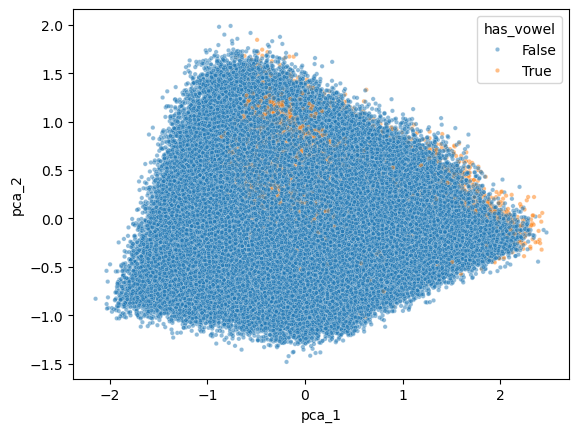

In [116]:
sns.scatterplot(data=instance_df, x="pca_1", y="pca_2", hue="has_vowel", s=10, alpha=0.5)

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, KFold

In [26]:
# from collections import Counter
# timit_dataset = datasets.load_from_disk("outputs/preprocessed_data/timit")
# repeat_texts = [text for text, _ in Counter(timit_dataset["text"]).most_common(2)]
# repeat_item_idxs = [idx for idx, text in enumerate(timit_dataset["text"]) if text in repeat_texts]
# # don't include repeat sentences in PCA evaluation
# train_df = instance_df.loc[~instance_df.index.get_level_values("item_idx").isin(repeat_item_idxs)]

In [27]:
# attempt to predict sonorant-ness of onset from PCA 1
X = train_df.pca_1.to_numpy()[:, None]
y = train_df.classifier_label

clf = LogisticRegressionCV(cv=KFold(5, shuffle=True), max_iter=1000)
clf.fit(X, y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(5, shuffle=True), scoring="roc_auc")
print(clf_scores)
print(clf_scores.mean())

[0.96241079 0.95933625 0.95883115 0.96102752 0.96168016]
0.9606571754686828


In [28]:
train_df["log_word_frequency"] = np.log10(train_df.word_frequency)

In [29]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df[["pca_2"]].to_numpy()),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None])[:, 0],
                cv=KFold(5, shuffle=True))

array([0.19139147, 0.19479802, 0.16638911, 0.18583456, 0.17688931])

In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

# explain variance in PC 2 from log word frequency
cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None]),
                StandardScaler().fit_transform(train_df[["pca_2"]].to_numpy()),
                cv=KFold(5, shuffle=True))

array([0.18628832, 0.1704666 , 0.18613036, 0.19134561, 0.18140551])

In [31]:
# explain variance in PC 1 from sonorant-ish label
cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                train_df.classifier_label.astype(int).to_numpy()[:, None],
                StandardScaler().fit_transform(train_df.pca_1.to_numpy()[:, None])[:, 0],
                cv=KFold(5, shuffle=True)).mean()

0.6337418290439712

In [32]:
sample_pts = np.linspace(instance_df.pca_1.min(), instance_df.pca_1.max(), 100)
decision_boundary = sample_pts[((clf.predict_proba(sample_pts[:, None])[:, 0] - 0.5) ** 2).argmin()]
decision_boundary

-0.5554807998982993

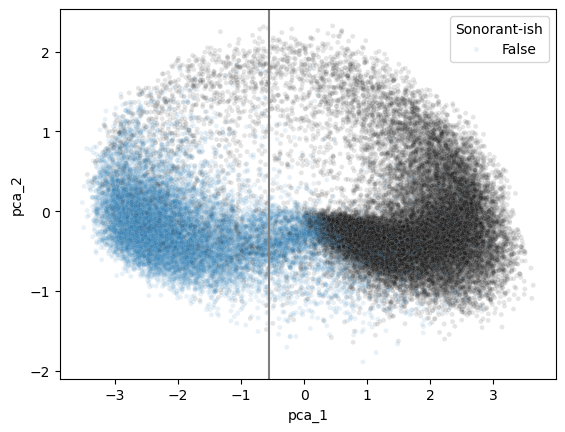

In [33]:
ax = sns.scatterplot(data=train_df.rename(columns={"classifier_label": "Sonorant-ish"}),
                     x="pca_1", y="pca_2", hue="Sonorant-ish", s=12, alpha=0.1)
ax.axvline(decision_boundary, color="gray")

<Axes: xlabel='word_frequency_quantile', ylabel='pca_2'>

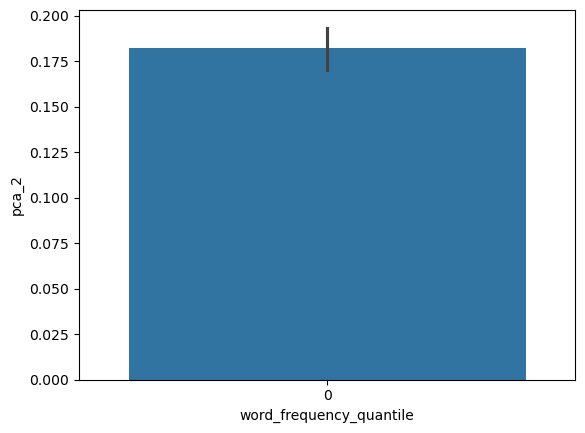

In [34]:
sns.barplot(data=train_df, x="word_frequency_quantile", y="pca_2")

In [35]:
train_df[train_df.pca_2.between(-0.5, 0.5)].sort_values("pca_1")

pca_1     pca_2     pca_3     pca_4  \
label      instance_idx item_idx                                           
tapestry   2            1651     -3.515872  0.108317  0.060810  0.000165   
porcupines 1            1767     -3.495362 -0.205342  0.080443 -0.009264   
process    7            2885     -3.488780  0.311395  0.030177  0.030341   
successors 0            1552     -3.440086  0.007375  0.065517  0.003558   
questions  1            1506     -3.438512 -0.069697  0.011339  0.052382   
...                                    ...       ...       ...       ...   
bayou      0            51        3.442400 -0.446833 -0.002269  0.032320   
oasis      6            4870      3.446794 -0.450217  0.002411 -0.024317   
lighted    1            3840      3.456459 -0.372353  0.026657 -0.046097   
highway    5            4916      3.464009 -0.464548  0.002986 -0.014146   
long       30           3433      3.468497 -0.417649  0.022633 -0.009896   

                                  num_syllables  monosyllabic  \
label      instance_idx item_idx                                
tapestry   2            1651                  3         False   
porcupines 1            1767                  3         False   
process    7            2885                  2         False   
successors 0            1552                  3         False   
questions  1            1506                  2         False   
...                                         ...           ...   
bayou      0            51                    2         False   
oasis      6            4870                  3         False   
lighted    1            3840                  2         False   
highway    5            4916                  2         False   
long       30           3433                  1          True   

                                 word_freq_lookup  word_frequency  \
label      instance_idx item_idx                                    
tapestry   2            1651             tapestry    2.086527e+09   
porcupines 1            1767           porcupines    2.086527e+08   
process    7            2885              process    1.919257e+11   
successors 0            1552           successors    8.114271e+08   
questions  1            1506            questions    1.748973e+11   
...                                           ...             ...   
bayou      0            51                  bayou    1.796732e+09   
oasis      6            4870                oasis    5.332235e+09   
lighted    1            3840              lighted    2.283588e+09   
highway    5            4916              highway    4.345772e+10   
long       30           3433                 long    7.137545e+11   

                                 word_frequency_quantile onset_phoneme  \
label      instance_idx item_idx                                         
tapestry   2            1651                           0             T   
porcupines 1            1767                           0             P   
process    7            2885                           1             P   
successors 0            1552                           0             S   
questions  1            1506                           1             K   
...                                                  ...           ...   
bayou      0            51                             0             B   
oasis      6            4870                           0            OW   
lighted    1            3840                           0             L   
highway    5            4916                           0            HH   
long       30           3433                           1             L   

                                 onset_biphone  classifier_label  \
label      instance_idx item_idx                                   
tapestry   2            1651              T EY             False   
porcupines 1            1767              P AO             False   
process    7            2885               P R             False   
s

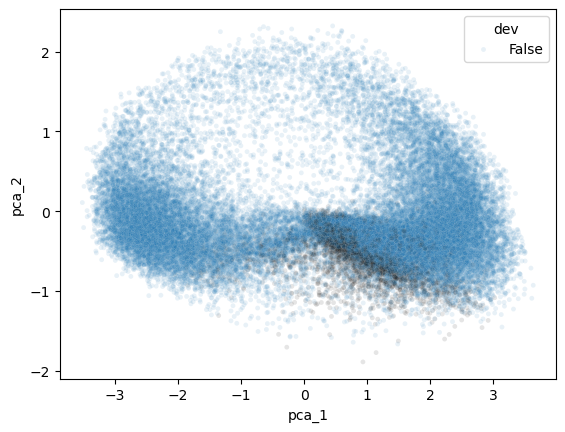

In [36]:
pca1_targets = ("don't", "did", "this", "didn't", "these", "do", "does", "it", "be",
                "then", "is", "he", "she", "get", "the", "into", "we", "a", "needs", "need",
                "used", "take", "use", "those", "took", "it's", "eat", "eating",
                "his", "can", "their", "any", "her", "got", "been", "could", "make", "makes",
                "come", "came", "they", "has")
train_df["dev"] = train_df.index.get_level_values("label").isin(
    pca1_targets)
ax = sns.scatterplot(data=train_df, x="pca_1", y="pca_2", hue="dev", s=12, alpha=0.1)

In [37]:
inspect = train_df.groupby("label").pca_2.agg(["mean", "std"]).sort_values("mean")
inspect = inspect[~inspect.index.isin(pca1_targets)]
inspect.head(20)

mean       std
label                         
ghettos    -1.519661       NaN
establish  -1.483792       NaN
daydreamed -1.470488       NaN
ingenuity  -1.453333       NaN
define     -1.411073       NaN
terrier    -1.409647       NaN
diet       -1.362923       NaN
addressed  -1.347471       NaN
together   -1.345647  0.140893
pansies    -1.317672       NaN
dyeing     -1.301707       NaN
betide     -1.294784       NaN
dad        -1.283833  0.114660
today'll   -1.281656       NaN
debut      -1.260158       NaN
disliked   -1.223049       NaN
donate     -1.222541       NaN
knees      -1.220996       NaN
dew        -1.212915  0.365317
downtown   -1.207946       NaN

In [38]:
from scipy.stats import spearmanr, pearsonr
pearsonr(train_df.pca_2, train_df.log_word_frequency)

PearsonRResult(statistic=-0.4282595138622742, pvalue=0.0)

In [39]:
train_df[(~train_df.dev) & (train_df.pca_1 < 0)].sort_values("pca_2").head(20)

pca_1     pca_2     pca_3     pca_4  \
label     instance_idx item_idx                                           
possessed 0            2481     -0.223000 -1.577355  0.031329 -0.050555   
thought   8            3688     -0.128919 -1.570651  0.039261  0.030766   
dig       2            4449     -0.220341 -1.567555 -0.042058 -0.010831   
die       1            745      -0.730423 -1.508253 -0.001799 -0.018042   
establish 0            4576     -0.598017 -1.483792  0.034326 -0.041794   
deadline  0            71       -0.382415 -1.457448  0.077728 -0.027594   
daphne's  2            4478     -0.924966 -1.427889  0.040959 -0.052514   
terrier   0            89       -0.581959 -1.409647 -0.079444  0.028936   
say       8            2930     -0.496181 -1.406319  0.089660  0.039303   
dishes    3            4086     -1.067103 -1.405597 -0.069020  0.004764   
seemed    5            1816     -0.254924 -1.387397  0.001739 -0.012520   
stag      5            3478     -1.159039 -1.374971  0.028312 -0.068307   
dolphins  0            1597     -0.254072 -1.368856  0.087803 -0.042621   
healthier 6            5028     -0.164946 -1.363964  0.012085 -0.022595   
survive   2            205      -0.296629 -1.362771 -0.011036  0.044778   
dolphins  4            2645     -0.399283 -1.347930  0.126371 -0.045653   
sing      6            2622     -0.854715 -1.345672  0.001994 -0.034297   
deadline  3            1839     -0.728621 -1.339759  0.037062 -0.019738   
sing      4            1974     -0.222366 -1.329702 -0.018405 -0.022961   
dishes    2            3774     -1.108155 -1.320399 -0.067308  0.012211   

                                 num_syllables  monosyllabic word_freq_lookup  \
label     instance_idx item_idx                                                 
possessed 0            2481                  2         False        possessed   
thought   8            3688                  1          True          thought   
dig       2            4449                  2         False              dig   
die       1            745                   1          True              die   
establish 0            4576                  3         False        establish   
deadline  0            71                    2         False         deadline   
daphne's  2            4478                  2         False           daphne   
terrier   0            89                    3         False          terrier   
say       8            2930                  1          True              say   
dishes    3            4086                  2         False           dishes   
seemed    5            1816                  1          True           seemed   
stag      5            3478                  1          True             stag   
dolphins  0            1597                  2         False         dolphins   
healthier 6            5028                  3         False        healthier   
survive   2            205                   2         False          survive   
dolphins  4            2645                  2         False         dolphins   
sing      6            2622                  2         False             sing   
deadline  3            1839                  2         False         deadline   
sing      4            1974                  1          True             sing   
dishes    2            3774                  2         False           dishes   

                                 word_frequency word_frequency_quantile  \
label     instance_idx item_idx                                           
possessed 0            2481        4.787420e+09                       0   
thought   8            3688        5.153374e+11                       1   
dig       2            4449        2.952436e+10                       0   
die       1            745         1.171585e+11                       1   
establish 0            4576        1.899899e+10                       0   
deadline  0            71          3.268892e+10                       0   
da

In [40]:
train_df.to_csv("20240510-train_df.csv")

In [41]:
instance_df["classifier_dec"] = clf.decision_function(instance_df.pca_1.to_numpy()[:, None])
instance_df['classifier_proba'] = clf.predict_proba(instance_df.pca_1.to_numpy()[:, None])[:, 0]
instance_df["classifier_output"] = instance_df.classifier_dec < 0

train_df["classifier_dec"] = clf.decision_function(train_df.pca_1.to_numpy()[:, None])
train_df['classifier_proba'] = clf.predict_proba(train_df.pca_1.to_numpy()[:, None])[:, 0]
train_df["classifier_output"] = train_df.classifier_dec < 0

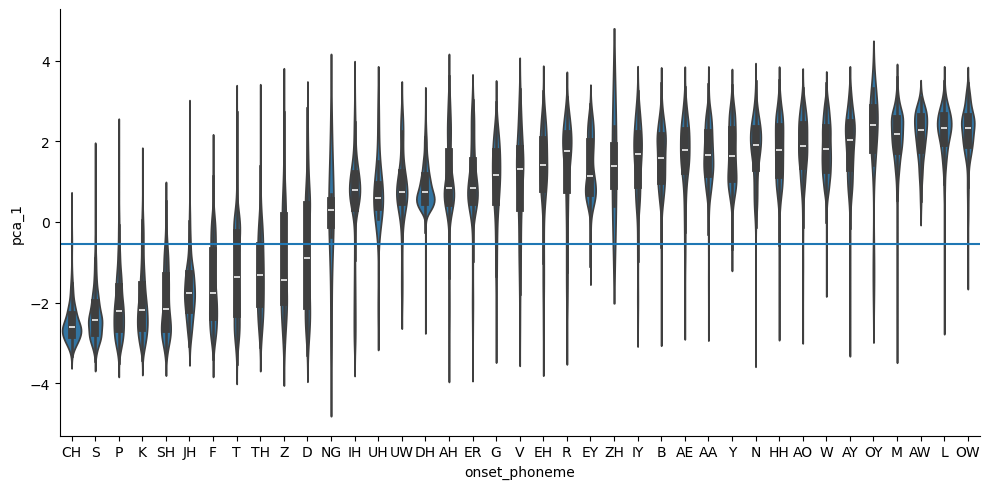

In [42]:
g = sns.catplot(data=train_df, x="onset_phoneme", y="pca_1", kind="violin",
                order=train_df.groupby("onset_phoneme").pca_1.mean().sort_values().index, aspect=2)
g.axes.flat[0].axhline(decision_boundary)

In [43]:
diverse_pca1 = train_df.groupby(["onset_phoneme"]).classifier_output.mean().sort_values()
diverse_pca1 = diverse_pca1[diverse_pca1.between(0.5 - 0.1, 0.5 + 0.1)]
diverse_pca1

onset_phoneme
D    0.550355
Name: classifier_output, dtype: float64

In [44]:
train_df.groupby("onset_phoneme").pca_1.agg(["mean", "std"]).sort_values("mean").dropna()

mean       std
onset_phoneme                    
CH            -2.494743  0.503516
S             -2.310694  0.616404
P             -2.078830  0.775031
K             -2.007712  0.836243
SH            -1.975994  0.832906
JH            -1.675553  0.768098
F             -1.563490  0.960703
T             -1.275190  1.152152
TH            -1.259894  0.994941
Z             -0.981825  1.327477
D             -0.804706  1.417241
NG             0.077888  1.488686
IH             0.498229  1.301014
UH             0.685535  0.953423
UW             0.797480  0.931950
DH             0.876121  0.526204
AH             0.902451  1.269499
ER             0.919144  1.097722
G              0.995553  1.052776
V              1.027452  1.250060
EH             1.218175  1.190696
R              1.306390  1.280916
EY             1.341921  0.768828
ZH             1.390688  1.392912
IY             1.479239  1.041792
B              1.489116  0.901148
AE             1.624492  0.938345
AA             1.647747  0.757823
Y              1.674646  0.747084
N              1.720343  0.901805
HH             1.741796  0.793963
AO             1.786279  0.878787
W              1.798949  0.696953
AY             1.855211  0.863646
OY             2.029025  1.314480
M              2.083445  0.713356
AW             2.147182  0.591649
L              2.191495  0.718529
OW             2.206610  0.658218

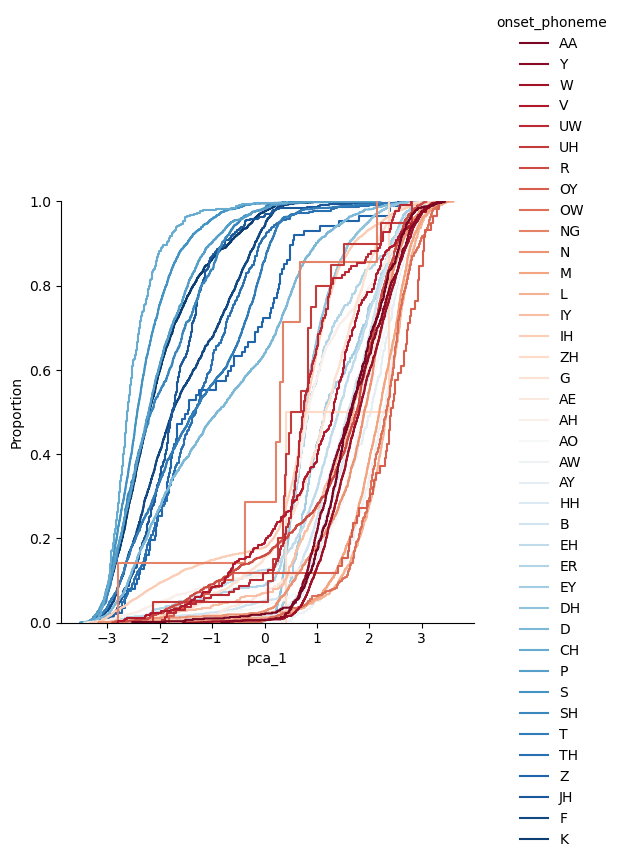

In [45]:
sns.displot(data=train_df, x="pca_1", hue="onset_phoneme", kind="ecdf",
            hue_order=train_df.groupby("onset_phoneme").classifier_output.median().sort_values().index,
            palette="RdBu")

In [46]:
train_df.loc["shoes"]

pca_1     pca_2     pca_3     pca_4  num_syllables  \
instance_idx item_idx                                                          
0            374      -1.155261 -0.130902 -0.055960  0.110166              1   
1            421      -2.771002 -0.362397  0.026847  0.022932              1   
2            436      -2.990441 -0.506568  0.019687  0.033759              1   
3            798      -1.515098 -0.131565  0.018115  0.089330              1   
4            1357     -2.261322 -0.376952  0.022164  0.016920              1   
5            1574     -1.300665 -0.295193 -0.036439  0.096024              1   
6            1718     -1.404691 -0.249612 -0.013917  0.087010              1   
7            1742     -1.951027 -0.108735 -0.019475  0.058425              1   
8            1757     -2.694951 -0.387818  0.051458  0.054263              1   
9            2305     -2.013799 -0.474144  0.003822  0.015321              1   
10           2501     -2.481017 -0.570443  0.004314  0.023173              1   
11           2757     -2.946390 -0.553824 -0.018630  0.041409              1   
12           2789     -3.008468 -0.363235  0.029492  0.024902              1   
13           3286     -2.169346 -0.131749 -0.013599  0.082910              1   
14           3470     -1.889351 -0.178316 -0.015994  0.071113              1   
15           3882     -3.014475 -0.181414 -0.008579  0.074136              1   
16           3928     -2.920019 -0.444986  0.020835  0.050551              1   
17           3966     -1.028797 -0.828403 -0.001454  0.074877              1   
18           4118     -2.328582 -0.428826 -0.032968  0.032555              1   
19           4150      1.200694 -1.384403 -0.065630  0.071186              1   
20           4326     -2.556692 -0.790813 -0.075480  0.038506              1   
21           4582     -2.672122 -0.333705 -0.027157  0.041688              1   
22           4662     -2.042707 -0.738795 -0.030316  0.027242              1   
23           4822     -2.609269 -0.550187 -0.044613  0.035398              1   

                       monosyllabic word_freq_lookup  word_frequency  \
instance_idx item_idx                                                  
0            374               True            shoes    8.470140e+10   
1            421               True            shoes    8.470140e+10   
2            436               True            shoes    8.470140e+10   
3            798               True            shoes    8.470140e+10   
4            1357              True            shoes    8.470140e+10   
5            1574              True            shoes    8.470140e+10   
6            1718              True            shoes    8.470140e+10   
7            1742              True            shoes    8.470140e+10   
8            1757              True            shoes    8.470140e+10   
9            2305              True            shoes    8.470140e+10   
10           2501              True            shoes    8.470140e+10   
11           2757              True            shoes    8.470140e+10   
12           2789              True            shoes    8.470140e+10   
13           3286              True            shoes    8.470140e+10   
14           3470              True            shoes    8.470140e+10   
15           3882              True            shoes    8.470140e+10   
16           3928              True            shoes    8.470140e+10   
17           3966              True            shoes    8.470140e+10   
18           4118              True            shoes    8.470140e+10   
19           4150              True            shoes    8.470140e+10   
20           4326              True            shoes    8.470140e+10   
21           4582              True            shoes    8.470140e+10   
22           4662              True            shoes    8.470140e+10   
23           4822              True            shoes    8.470140e+10   

                      word_frequency_quantile onset_phoneme onset_biphon

## Model embedding projections

In [47]:
def plot_trajectory(output_dims, plot_type, trajectory_idxs=None, ax=None):
    if trajectory_idxs is None or isinstance(trajectory_idxs, int):
        trajectory_idxs = np.random.choice(all_trajectories_full.shape[0], size=trajectory_idxs, replace=False)

    assert len(output_dims) in [2, 3]
    assert output_dims == 2 or plot_type == "line", "need line plot if 3d"

    assert all_trajectories_full.shape[1] == 1
    plot_trajs = all_trajectories_full[trajectory_idxs, 0, :]

    # project into expected model activation space
    # TODO this isn't actually a fair rollout since we're ignoring other model features
    einsum_result = np.einsum("bd,fodt->fobt", plot_trajs, model_embedding_coefs)

    if ax is None:
        ax = plt.figure().add_subplot(projection='3d' if len(output_dims) == 3 else None)
    cmap = sns.color_palette("Set1", einsum_result.shape[2])
    for traj_idx in range(einsum_result.shape[2]):
        traj_label_idx, traj_instance = all_trajectories_src[trajectory_idxs[traj_idx]]
        traj_label = state_space_spec.labels[traj_label_idx]

        traj_data = einsum_result[:, output_dims][:, :, traj_idx, :].mean(axis=0).T
        # state_space_points = np.concatenate([np.zeros((1, 2)), traj_data], axis=0)
        state_space_points = traj_data

        if plot_type == "line":
            ax.plot(state_space_points[:, 0], state_space_points[:, 1],
                    marker="o" if traj_idx % 2 == 0 else "x",
                    label=traj_label, color=cmap[traj_idx], alpha=0.5)

            # mark starts
            ax.scatter(state_space_points[0, 0], state_space_points[0, 1],
                       marker="o" if traj_idx % 2 == 0 else "x", s=15)
        elif plot_type == "quiver":
            ax.quiver(state_space_points[:-1, 0], state_space_points[:-1, 1],
                      state_space_points[1:, 0] - state_space_points[:-1, 0],
                      state_space_points[1:, 1] - state_space_points[:-1, 1],
                      label=traj_label, alpha=0.5, color=cmap[traj_idx], scale=0.01)

    ax.set_xlabel(str(output_dims[0]))
    ax.set_ylabel(str(output_dims[1]))

    if len(trajectory_idxs) <= 20:
        ax.legend()
    return ax

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

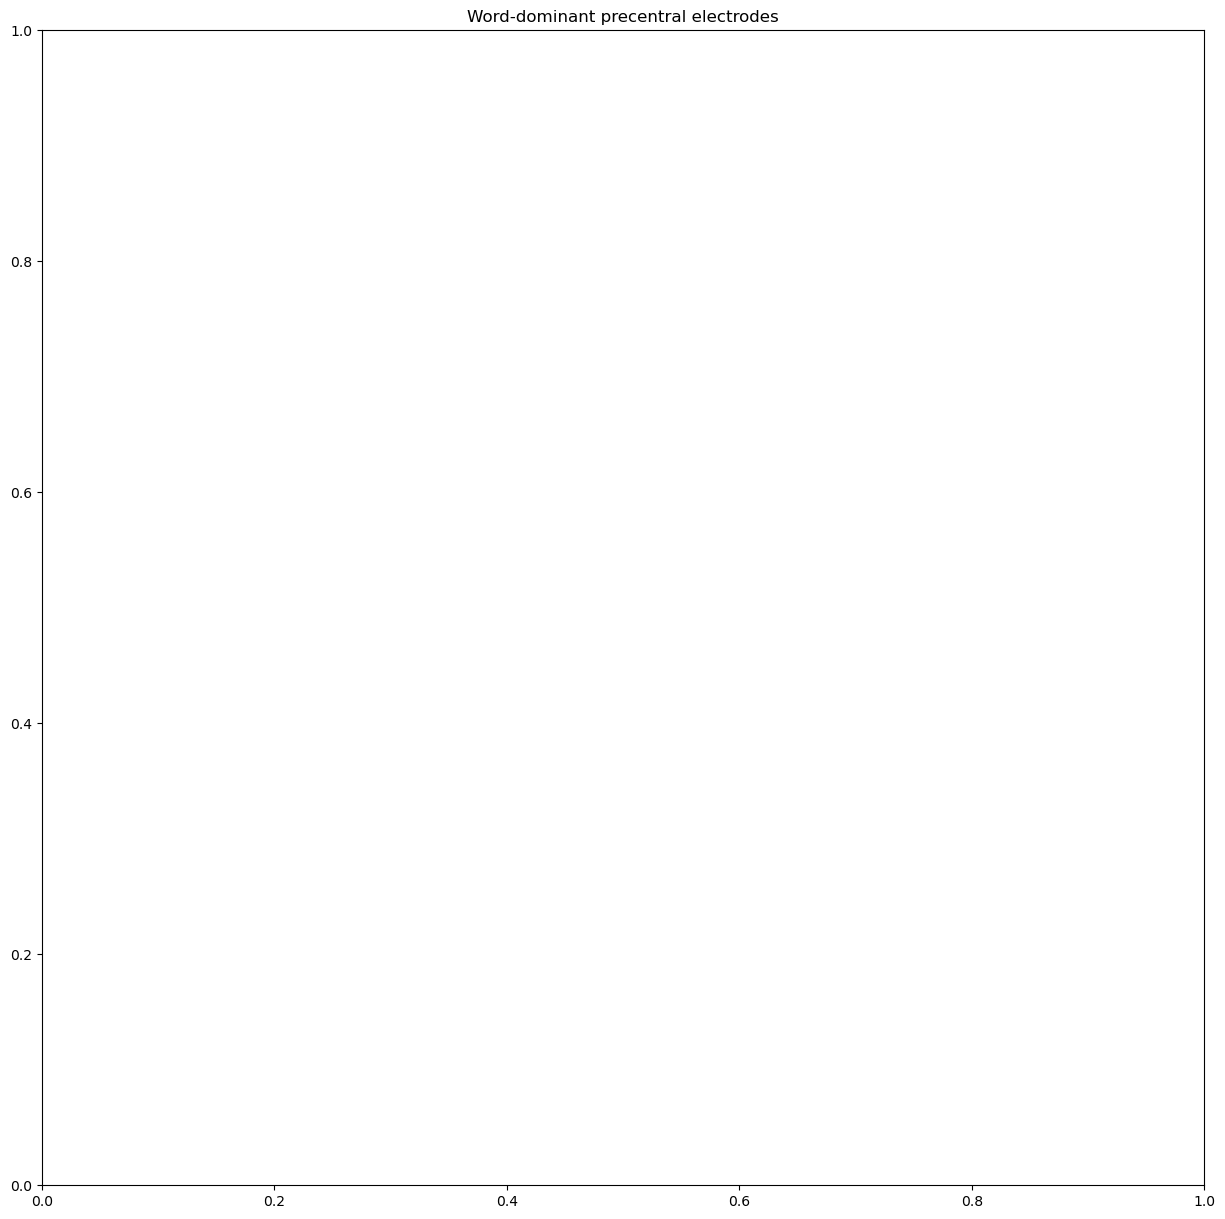

In [48]:
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Word-dominant precentral electrodes")
plot_trajectory([57, 107], "line", 20, ax=ax)

<Axes: title={'center': 'Word-dominant STG electrodes'}, xlabel='214', ylabel='230'>

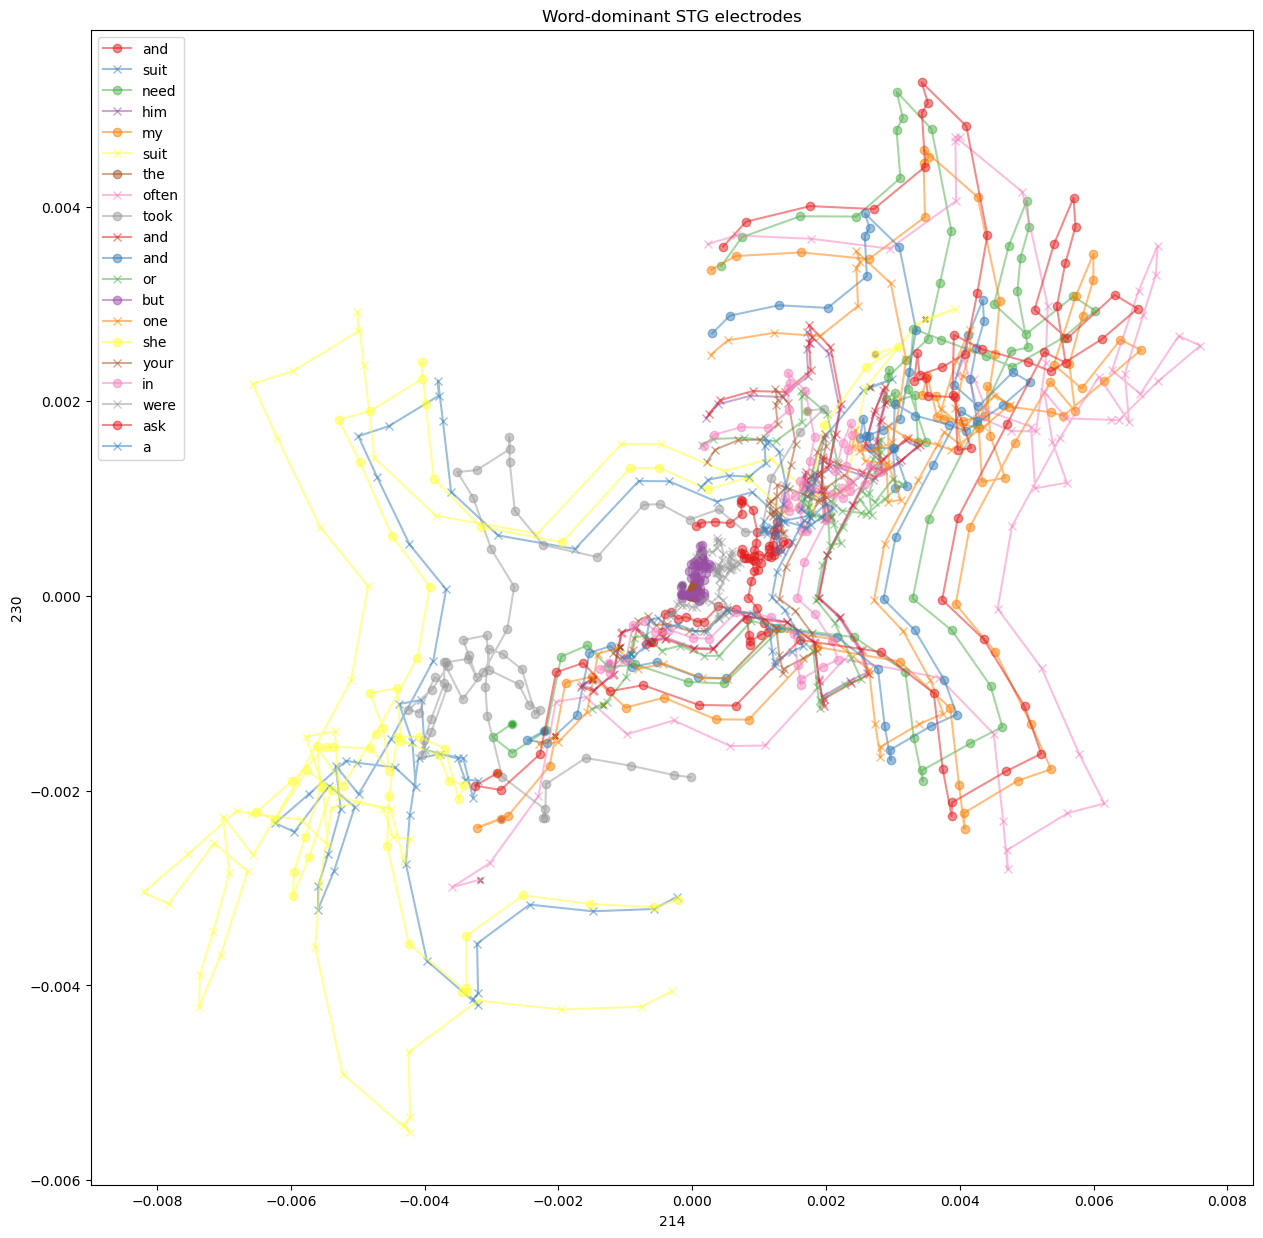

In [ ]:
ax = plt.subplots(figsize=(15, 15))[1]
ax.set_title("Word-dominant STG electrodes")
plot_trajectory([214, 230], "line", 20, ax=ax)

<Axes3D: title={'center': 'Word-dominant STG electrodes'}, xlabel='220', ylabel='214'>

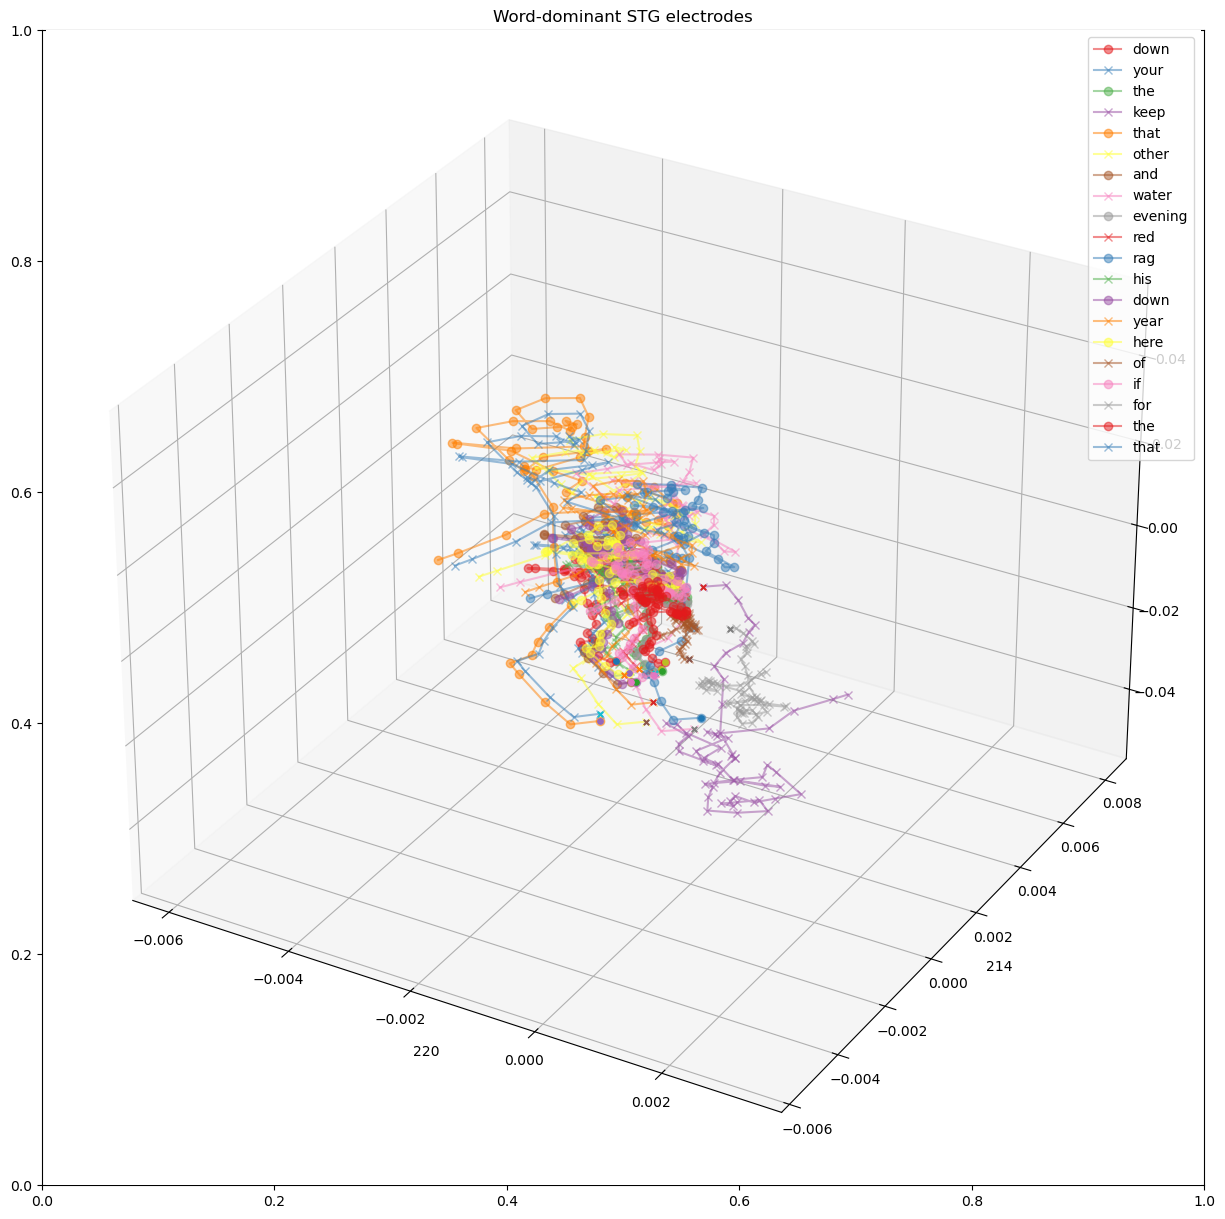

In [ ]:
ax = plt.subplots(figsize=(15, 15))[0].add_subplot(projection='3d')
ax.set_title("Word-dominant STG electrodes")
plot_trajectory([220, 214, 230], "line", 20, ax=ax)